In [26]:
import pandas as pd

df1 = pd.read_csv("employment.csv", encoding='cp949')
df2 = pd.read_excel("grdp.xlsx")


In [27]:

df1 = df1.T
print(df1.head())

                    0     1      2      3      4      5      6      7      8    
시도별                시도별     계  서울특별시  부산광역시  대구광역시  인천광역시  광주광역시  대전광역시  울산광역시  \
2000           고용률 (%)  58.5   58.2   55.4     56   58.2   53.4   54.8   57.6   
2000.1  15-64세 고용률 (%)  61.5   60.9   58.4   59.2   61.5   55.9   57.8   59.3   
2001           고용률 (%)    59   58.8   55.9     57   59.1   54.9   56.5   58.1   
2001.1  15-64세 고용률 (%)  62.2   61.5   59.3   60.3   62.6   57.4   59.7     60   

             9     10    11    12    13    14    15    16    17    18  
시도별     세종특별자치시   경기도   강원도  충청북도  충청남도  전라북도  전라남도  경상북도  경상남도   제주도  
2000          -  59.8  57.3  57.9  61.1  56.5    62    63  58.9  66.1  
2000.1        -  63.1  60.9  61.6  64.5  59.8  65.2    66  62.1    69  
2001          -    60  56.7  57.8  61.3  57.4  62.9  63.5  59.5  66.5  
2001.1        -  63.4  60.5  61.6  65.2    61  65.9  66.6  63.1  69.8  


        0     1     2     3     4     5     6  7  8     9    10    11     12   
1986  10.8  10.8   9.1  10.8   9.8     -     -  -  -  16.3  8.3   2.1   11.1  \
1987  12.3  13.8  10.4  12.9  13.5     -     -  -  -  17.9  7.2   5.5    6.7   
1988  12.1  10.6   9.5   7.7  15.1  20.7     -  -  -  14.6  4.3  11.4   12.3   
1989   6.9   7.6   1.4   4.2   7.3   7.2     -  -  -  10.0  4.8  10.6  -26.8   
1990  10.3  10.3  14.7  13.6  15.8  13.6  14.5  -  -  13.2  4.3  10.2    1.0   

        13     14    15    16    17  
1986   8.2    6.9  15.5  10.0   3.5  
1987   4.1  -15.8  11.7  10.7  12.9  
1988  13.7   13.5  14.6  13.1   9.4  
1989   0.0    2.3   0.5   6.1  21.9  
1990   4.0    7.7   2.9  11.9   1.3  


<AxesSubplot: >

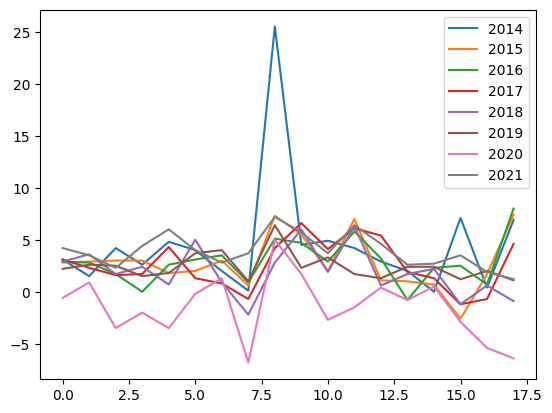

In [47]:
#df2.drop(columns='Unnamed: 0', axis=1, inplace=True)
print(df2.head())
df2 = df2.T
df2.plot()
#print(df2.columns)

ValueError: could not convert string to float: '전국'